<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Bayesian Statistics With Baseball Data: Priors and Posteriors

_Authors: Kiefer Katovich (SF)_

---

Let’s review the general set up for Bayesian modeling. We have:

### $$P\left(\;model\;|\;data\;\right) = \frac{P\left(\;data\;|\;model\;\right)}{P(\;data\;)} P\left(\;model\;\right)$$

This is the diachronic interpretation of Bayes' theorem.

It can also be written as:

### $$posterior \propto likelihood \cdot prior$$

Here, the posterior is an update of our prior belief given the data observed.

## Bayesian Analysis of Batting Averages

---

Load in the simple batting average data for players below. There are just four fields in the data set: the player's name, their times at bat, their hits, and their batting average.

> *Note: [This section of the lab is a partial replication of this exercise in R, if you're interested](https://www.r-bloggers.com/understanding-empirical-bayes-estimation-using-baseball-statistics/). Here, we took out the empirical Bayes section because it's not technically a correct interpretation of Bayesian statistical analysis.*

In [41]:
import pandas as pd
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [4]:
# A:
df = pd.read_csv('datasets/career_hits.csv')

In [8]:
# no nulls, str/int/int/float, GTFG
df.head()

,name,hits,at_bat,average
0,Hank Aaron,3771,12364,0.304998
1,Tommie Aaron,216,944,0.228814
2,Andy Abad,2,21,0.095238
3,John Abadie,11,49,0.224490
4,Ed Abbaticchio,772,3044,0.253614


### 1) Find the top and bottom three hitters according to their average.

What is wrong with using the average to find the three best and worst hitters?

In [16]:
# A:
df.groupby('name')['average'].mean().sort_values(ascending=False)[:5]
# we can see that we have more than 3 people who scored the max and min
# values so we can't pick a 'top 3' since it's a tie

name
Doc Bass        1.0
Heinie Odom     1.0
Dave Liddell    1.0
Name: average, dtype: float64

In [10]:
# also note that we needed a groupby since we have multiple
# records for the same name
pd.value_counts(df['name'])

John Sullivan        4
Dick Smith           3
Mike Fitzgerald      3
Jack Farrell         3
Dave Roberts         3
Joe Walsh            3
Luis Lopez           3
Earl Smith           3
Mike Ryan            3
Pete O'Brien         3
Craig Wilson         3
Harry Smith          3
Bob Johnson          3
Jim Clark            3
Red Smith            3
John Smith           3
Pat Kelly            3
Harl Maggert         2
Charlie Miller       2
Randy Johnson        2
Bill Smith           2
Sam Crane            2
Frank Thomas         2
Henry Rodriguez      2
Harry Taylor         2
John Glenn           2
Brian Giles          2
Billy Williams       2
Sandy Alomar         2
Roy Johnson          2
                    ..
Eddie Brown          1
Maury Pierce         1
Carr Smith           1
Ernie Sulik          1
Joel Skinner         1
Nelson Mathews       1
Jorge Toca           1
Yadier Molina        1
Ed Delahanty         1
Jorge Cantu          1
Dutch Distel         1
Will Middlebrooks    1
Corky Withr

### 2) Set up a prior distribution to represent our belief about batting average.

[After doing a quick search online](https://www.google.com/search?q=average+batting+average+for+players+mlb&oq=average+batting+average+for+players+mlb&aqs=chrome..69i57j0.7373j0j4&sourceid=chrome&ie=UTF-8), it looks like the overall batting average for MLB baseball players is around 0.260.

**Let's make it simple and say that our prior belief is that, out of 100 at-bats, we’ve seen 26 hits. Set up a beta distribution with `alpha=27` and `beta=75`. Plot it with the function from above.**

This is our distribution of beliefs on the batting average (probability of hitting while at bat) for MLB players.

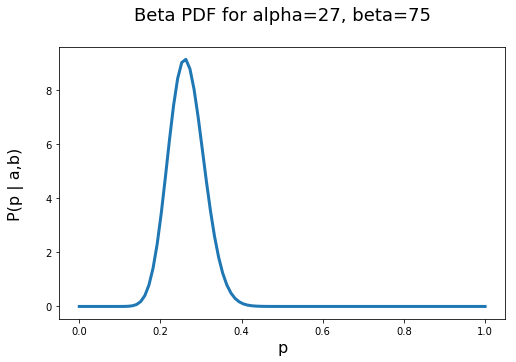

In [57]:
a = 27 # alpha, number of successes (27 hits out of 100 at bat)
b = 75 # beta, number of failures (75 misses out of 100 at bat)
beta = stats.beta(a, b) # add one to make sure it's non-zero prob
# that is to make sure you don't have a flat probability curve

fig, ax = plt.subplots(figsize=(8, 5))
pvals = np.linspace(0.,1.,100) # probability of success
like = beta.pdf(pvals) # likelihood of that probability of success

ax.plot(pvals, like, lw=3)
ax.set_xlabel('p', fontsize=16)
ax.set_ylabel('P(p | a,b)\n', fontsize=16)
ax.set_title('Beta PDF for alpha={}, beta={}\n'.format(a,b), fontsize=18)
plt.show()

### 3) Calculate the maximum a posteriori (MAP) estimate of players' batting averages.

The maximum a posteriori (MAP) estimate is the mode of a posterior distribution for a statistical parameter.

In our case, the MAP estimate for our players' batting averages will be the mode of the posterior beta distribution we get from updating our prior distribution with their at bats and hits.

---

> *Note: For an additional overview of the math behind updating the beta distribution posterior and conjugate priors, ([check out this website](https://alexanderetz.com/2015/07/25/understanding-bayes-updating-priors-via-the-likelihood/)).*

We need to update our beta distribution’s prior belief about batting averages with a player's at-bat and hit information to get a _new_ beta posterior distribution for that player's batting average. 

Luckily, with the beta distribution, the update is just a matter of adding in our new observations to the alpha and beta parameters, where alpha is the number of hits and beta is the number of misses/strikes:

    observed_hits = n_hits
    observed_misses = n_misses
    beta_prior = Beta(prior_hits+1, prior_misses+1)
    beta_posterior = Beta(prior_hits + n_nits + 1, prior_misses + n_misses + 1)
    
> **Note:** This process will also be useful in the context of A/B testing, which we’ll look at later on.

For each player, update the prior to the posterior distribution and calculate the mode of the distribution. The mode of a beta distribution is conveniently defined as:

### $$ \frac{\alpha_{post} - 1}{\alpha_{post} + \beta_{post} -2} $$

Which means we don't even need to use SciPy's beta distribution function. Just calculate the new alpha (hits) and beta (misses) for each player's posterior beta distribution and plug them into the formula above to get the MAP estimate of batting the average.

In [62]:
# A:
# create a misses column
df['misses'] = df.copy()['at_bat'] - df.copy()['hits']

In [65]:
df.head(2)

,name,hits,at_bat,average,misses
0,Hank Aaron,3771,12364,0.304998,8593
1,Tommie Aaron,216,944,0.228814,728


**Now let's update our global prior (26 hits out of 100) to a batter-specific posterior:**

### $$ \begin{aligned}
\alpha_{posterior} &= k + \alpha_{prior} \\
\beta_{posterior} &= n - k + \beta_{prior}
\end{aligned} $$

Note that n-k is the same as at_bat - hits, which is misses

In [110]:
# n is the total number of times at bat (opportunities for success)
# k is the number of successes we had (hits)
df['a_post'] = df.copy()['hits'] + a # a is is our alpha prior
df['b_post'] = df.copy()['at_bat'] - df.copy()['hits'] + b # b is our beta prior

# generate MAP column (use the posteriors!)
# this is the new probability of success for each batter
# for example, 0.304637 is a 30.3% chance of hitting the ball
df['map'] = (df.copy()['a_post'] - 1) / (df.copy()['a_post'] + df.copy()['b_post'] - 2)

In [116]:
df['map'][:3]

0    0.304637
1    0.231801
2    0.231405
Name: map, dtype: float64

### 4) Look up the top and bottom batters according to the MAP estimate.

In [120]:
# top 3
df[['name', 'map']].sort_values('map', ascending=False)[:3]

,name,map
3938,Rogers Hornsby,0.357307
4118,Shoeless Joe Jackson,0.353867
2109,Ed Delahanty,0.344773


In [125]:
# bottom 3
df[['name', 'map']].sort_values('map', ascending=False)[-3:]

,name,map
2987,Ed Gastfield,0.170213
4322,Mike Jordan,0.168889
4031,John Humphries,0.168103


### 5) Plot the MLE batting average against the MAP batting average.

In [134]:
# we're going to show the MLE (prior) and MAP (posterior) for 
# ONE PLAYER only! The top playa-playy, Rogers Hornsby:
df[df['name'] == 'Rogers Hornsby']

,name,hits,at_bat,average,misses,map,a_post,b_post
3938,Rogers Hornsby,2930,8173,0.358497,5243,0.357307,2957,5318


In [132]:
MLE = stats.beta(a, b)
# try it only for one player, Rogers Hornsby!
MAP = stats.beta(df[df['name'] == 'Rogers Hornsby']['hits'] + a,
                 df[df['name'] == 'Rogers Hornsby']['misses'] + b)

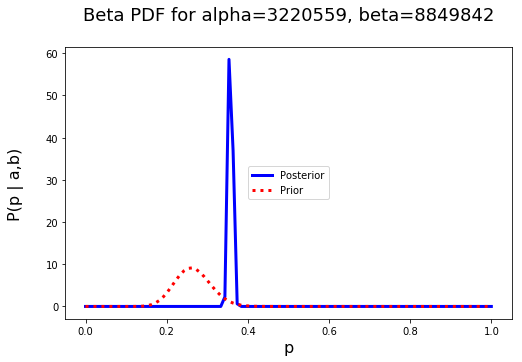

In [140]:
fig, ax = plt.subplots(figsize=(8, 5))
pvals = np.linspace(0.,1.,100) # probability of success
prior = MLE.pdf(pvals) # PRIOR likelihood of that probability of success
post = MAP.pdf(pvals)

ax.plot(pvals, post, 'b', lw=3, label='Posterior')
ax.plot(pvals, prior, 'r:', lw=3, label='Prior')
#ax.plot(pvals, like, lw=3)
ax.set_xlabel('p', fontsize=16)
ax.set_ylabel('P(p | a,b)\n', fontsize=16)
ax.set_title('Beta PDF for alpha={}, beta={}\n'.format(df['hits'].sum() + a,
                                                       df['misses'].sum() + b), fontsize=18)
plt.legend(loc='center')
plt.show()